In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, DateType
from pyspark.sql import functions as F
from datetime import date
import matplotlib.pyplot as plt
import pandas as pd
import os

spark = SparkSession.builder.getOrCreate()

# ===== 1. Load Dataset =====
schema = StructType([
    StructField("order_id", StringType()),
    StructField("region", StringType()),
    StructField("category", StringType()),
    StructField("quantity", IntegerType()),
    StructField("price", DoubleType()),
    StructField("order_date", DateType())
])

data = [
    ("O001", "South", "Electronics", 3, 15000.0, date(2025, 1, 5)),
    ("O002", "North", "Clothing", 5, 2000.0, date(2025, 1, 6)),
    ("O003", "East", "Furniture", 2, 12000.0, date(2025, 1, 7)),
    ("O004", "West", "Electronics", 1, 18000.0, date(2025, 1, 8)),
    ("O005", "North", "Furniture", 4, 9000.0, date(2025, 1, 10)),
    ("O006", "South", "Clothing", 6, 2500.0, date(2025, 1, 11)),
    ("O007", "East", "Electronics", 2, 17000.0, date(2025, 1, 12)),
    ("O008", "South", "Furniture", 5, 8500.0, date(2025, 1, 15)),
    ("O009", "West", "Clothing", 7, 3000.0, date(2025, 1, 17)),
    ("O010", "North", "Electronics", 4, 16000.0, date(2025, 1, 18))
]

df = spark.createDataFrame(data, schema)
df.show(10, False)

# Create folder for saving PNGs
save_path = "/dbfs/FileStore/tables/sales_viz/"
os.makedirs(save_path, exist_ok=True)

+--------+------+-----------+--------+-------+----------+
|order_id|region|category   |quantity|price  |order_date|
+--------+------+-----------+--------+-------+----------+
|O001    |South |Electronics|3       |15000.0|2025-01-05|
|O002    |North |Clothing   |5       |2000.0 |2025-01-06|
|O003    |East  |Furniture  |2       |12000.0|2025-01-07|
|O004    |West  |Electronics|1       |18000.0|2025-01-08|
|O005    |North |Furniture  |4       |9000.0 |2025-01-10|
|O006    |South |Clothing   |6       |2500.0 |2025-01-11|
|O007    |East  |Electronics|2       |17000.0|2025-01-12|
|O008    |South |Furniture  |5       |8500.0 |2025-01-15|
|O009    |West  |Clothing   |7       |3000.0 |2025-01-17|
|O010    |North |Electronics|4       |16000.0|2025-01-18|
+--------+------+-----------+--------+-------+----------+



#2. Create a new column revenue = quantity × price .

In [9]:
df = df.withColumn("revenue", F.col("quantity") * F.col("price"))

#3. Generate a bar chart showing total revenue by category.

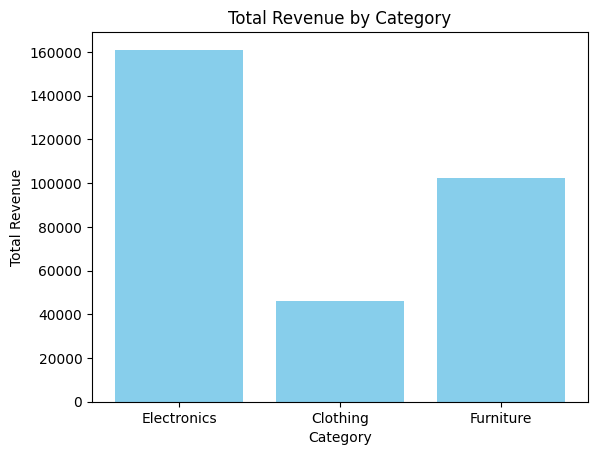

In [10]:
category_summary = df.groupBy("category").agg(F.sum("revenue").alias("total_revenue"))
pdf = category_summary.toPandas()

plt.bar(pdf["category"], pdf["total_revenue"], color="skyblue")
plt.xlabel("Category")
plt.ylabel("Total Revenue")
plt.title("Total Revenue by Category")
plt.savefig(f"{save_path}revenue_by_category.png")
plt.show()

#4. Create a line chart showing revenue trend by order_date (sorted by date).

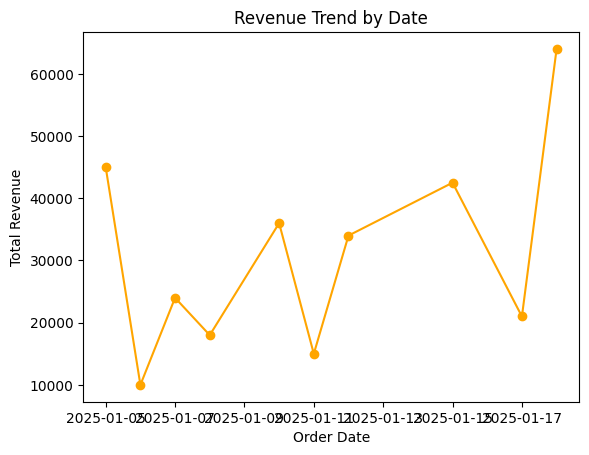

In [11]:
date_summary = df.groupBy("order_date").agg(F.sum("revenue").alias("total_revenue")).orderBy("order_date")
pdf = date_summary.toPandas()

plt.plot(pdf["order_date"], pdf["total_revenue"], marker="o", color="orange")
plt.xlabel("Order Date")
plt.ylabel("Total Revenue")
plt.title("Revenue Trend by Date")
plt.savefig(f"{save_path}revenue_trend.png")
plt.show()

#5. Create a pie chart showing percentage contribution of each region to total revenue.

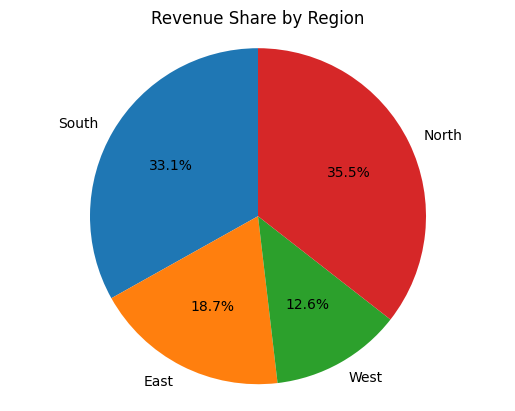

In [12]:
region_summary = df.groupBy("region").agg(F.sum("revenue").alias("total_revenue")).toPandas()

plt.pie(region_summary["total_revenue"], labels=region_summary["region"], autopct="%1.1f%%", startangle=90)
plt.title("Revenue Share by Region")
plt.axis("equal")
plt.savefig(f"{save_path}revenue_by_region_pie.png")
plt.show()

#6. Create a stacked bar chart comparing total quantity sold per category by region.

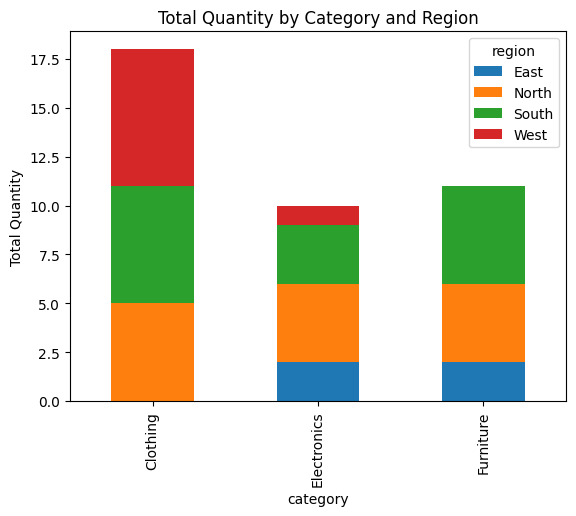

In [13]:
stack_data = df.groupBy("category", "region").agg(F.sum("quantity").alias("total_quantity")).toPandas()
pivot_df = stack_data.pivot(index="category", columns="region", values="total_quantity").fillna(0)

pivot_df.plot(kind="bar", stacked=True)
plt.title("Total Quantity by Category and Region")
plt.ylabel("Total Quantity")
plt.savefig(f"{save_path}stacked_quantity.png")
plt.show()

#7. Filter and visualize only top 5 products by total revenue in a horizontal bar chart.

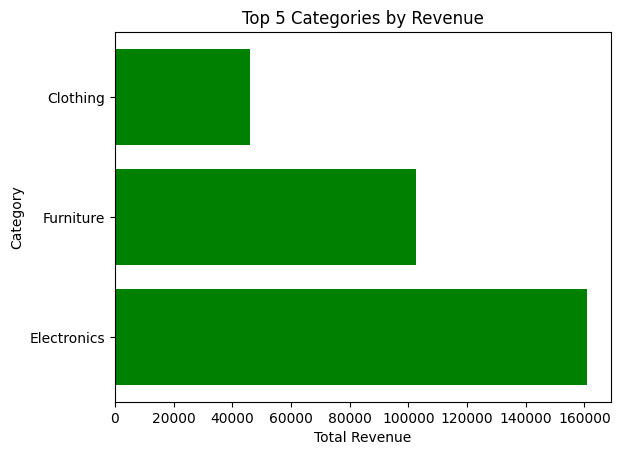

In [14]:
top5 = df.groupBy("category").agg(F.sum("revenue").alias("total_revenue")).orderBy(F.desc("total_revenue")).limit(5).toPandas()

plt.barh(top5["category"], top5["total_revenue"], color="green")
plt.xlabel("Total Revenue")
plt.ylabel("Category")
plt.title("Top 5 Categories by Revenue")
plt.savefig(f"{save_path}top5_categories.png")
plt.show()

#8. Create a scatter plot showing quantity vs price colored by category .

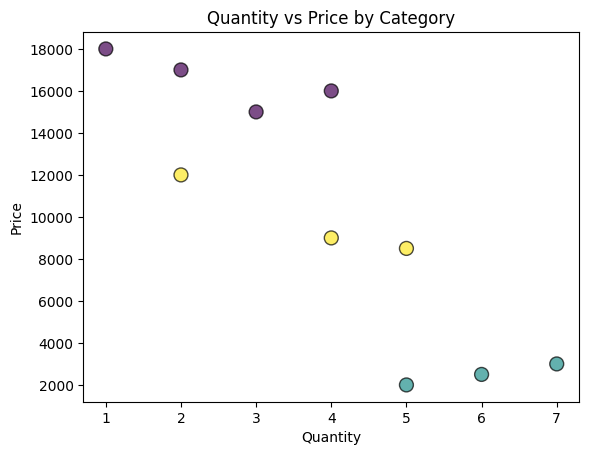

In [15]:
pdf = df.toPandas()
plt.scatter(pdf["quantity"], pdf["price"], c=pd.factorize(pdf["category"])[0], cmap="viridis", s=100, alpha=0.7, edgecolors="black")
plt.xlabel("Quantity")
plt.ylabel("Price")
plt.title("Quantity vs Price by Category")
plt.savefig(f"{save_path}scatter_quantity_price.png")
plt.show()

#9. Find average order value by region and plot it as a bar chart.

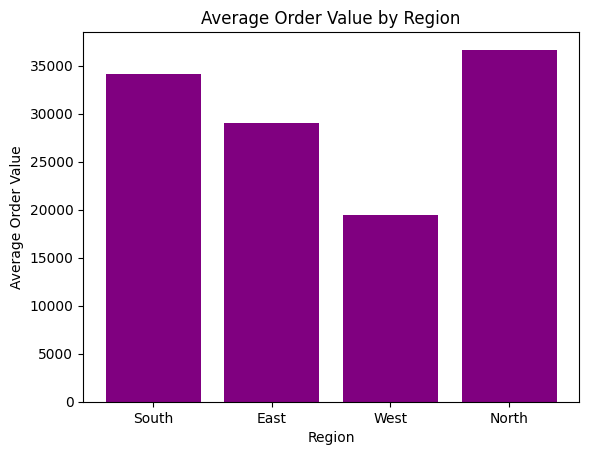

In [16]:
avg_order_value = df.groupBy("region").agg(F.avg("revenue").alias("avg_order_value")).toPandas()

plt.bar(avg_order_value["region"], avg_order_value["avg_order_value"], color="purple")
plt.xlabel("Region")
plt.ylabel("Average Order Value")
plt.title("Average Order Value by Region")
plt.savefig(f"{save_path}avg_order_value.png")
plt.show()

#10. Create a heatmap (pivot table in Databricks) showing revenue by region and category.

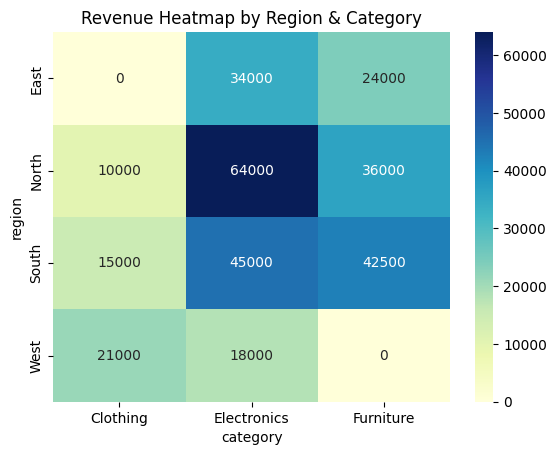

In [17]:
import seaborn as sns

heatmap_data = df.groupBy("region", "category").agg(F.sum("revenue").alias("total_revenue")).toPandas()
pivot_df = heatmap_data.pivot(index="region", columns="category", values="total_revenue").fillna(0)

sns.heatmap(pivot_df, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Revenue Heatmap by Region & Category")
plt.savefig(f"{save_path}heatmap_revenue.png")
plt.show()

#11. Bonus: Apply a discount column:
Electronics → 10% discount
Clothing → 5% discount
Furniture → 8% discount Plot discounted vs original revenue for each category
in a grouped bar chart.

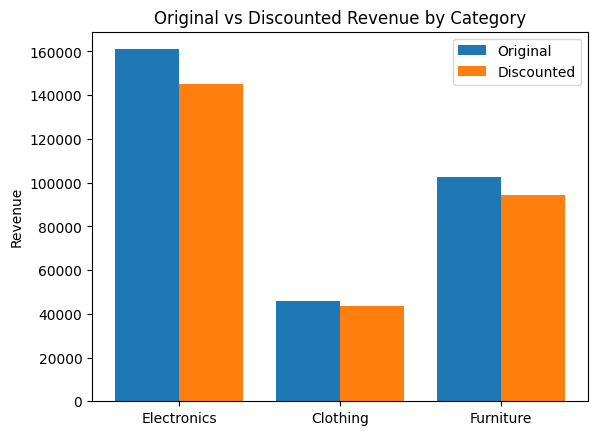

In [18]:
discounts = {"Electronics": 0.10, "Clothing": 0.05, "Furniture": 0.08}
discount_udf = F.udf(lambda cat, rev: float(rev) * (1 - discounts.get(cat, 0)), DoubleType())

df = df.withColumn("discounted_revenue", discount_udf(F.col("category"), F.col("revenue")))
disc_summary = df.groupBy("category").agg(
    F.sum("revenue").alias("original"),
    F.sum("discounted_revenue").alias("discounted")
).toPandas()

x = range(len(disc_summary))
plt.bar(x, disc_summary["original"], width=0.4, label="Original", align="center")
plt.bar([i + 0.4 for i in x], disc_summary["discounted"], width=0.4, label="Discounted", align="center")
plt.xticks([i + 0.2 for i in x], disc_summary["category"])
plt.ylabel("Revenue")
plt.title("Original vs Discounted Revenue by Category")
plt.legend()
plt.savefig(f"{save_path}discount_vs_original.png")
plt.show()

#12. Save all visualizations as PNG files to /dbfs/FileStore/tables/sales_viz/ .

In [19]:
print(f"All visualizations saved to {save_path}")

All visualizations saved to /dbfs/FileStore/tables/sales_viz/


In [30]:
import os
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files

# Paths
src_dir = "/dbfs/FileStore/tables/sales_viz/"
pdf_path = "/content/sales_viz_all.pdf"

# Create a PDF and add all PNGs to it
with PdfPages(pdf_path) as pdf:
    for file_name in sorted(os.listdir(src_dir)):  # sorted to keep order
        if file_name.endswith(".png"):
            img_path = os.path.join(src_dir, file_name)
            img = mpimg.imread(img_path)

            plt.figure(figsize=(8, 6))
            plt.imshow(img)
            plt.axis('off')
            pdf.savefig()  # Save current figure to PDF
            plt.close()

print(f"PDF created at {pdf_path}")

# Download PDF
files.download(pdf_path)

PDF created at /content/sales_viz_all.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>